In [120]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d as gf
%matplotlib notebook

# Performance of several 3D scalar field implementations

The goal here is to decide which of the several possible implementations of a 3D scalar field is the best for typical operations done in a PIC code. We typically have 2 major kinds of data access in a PIC code:

1. operations on fields, where data of the fields is accessed more or less regularly depending on the stencils
2. particle-field operations, where fields are accessed randomly depending on the particle positions. These operations can be of read or write types.


## Possible 3D scalar field implementations

We use 4 kinds of implementations for a 3D scalar field. They all share the same interface but differ in the way they allocate data.

### FieldA : multiple allocations

```cpp
private:
     double* data_;
     double ***data3D_;
     uint32 nx_, ny_, nz_;
public:
     void allocate()
     {
         data_ = new double[nx_ * ny_ * nz_];
         data3D_ = new double**[nx_];
         for (uint32 i=0;  i < nx_; ++i)
         {
             data3D_[i] = new double*[ny_];
             if (data3D_[i] == nullptr)
             {
                 throw std::runtime_error("Error");
             }
             for (uint32 j=0; j < ny_; ++j)
             {
                   data3D_[i][j] = data_ + i * nz_ * ny_ + j * nz_;
             }
         }
     }
```     

FieldA stores data in a 1D contiguous array `data`, but the pointer `double ***data3D` stores pointers in a way that allows an easy access :

```cpp
     inline double& operator()(uint32 i, uint32 j, uint32 k)
     {
        return data3D_[i][j][k];
     }
```
     
There can be several **drawbacks** to this implementation:

- allocation of the whole structure requires `nx_` memory allocation of `ny_` double* pointers.
- although `data_` is contiguous, `data3D_` is not and can be scattered in memory due to the several allocations. This may not be good for random accesses.
- manual dynamic allocation (`new`) requires to take care manually of copy construction/assignement and deletion which increases probabiliy of bugs.


### FieldB: contiguous std::vector

```cpp

private:
    uint32 nx_, ny_, nz_;
    std::vector <double> data_;

public:
    inline double& operator()(uint32 const i, uint32 const j, uint32 const k)
    {
        return data_[ k + (j + i*ny_)*nz_ ];
    }
```

FieldB encapsulates a `std::vector` that contiguously stores data in a linearized manner. The () operator just access data in a row-major way. 

**Advantages**:

- using `std::vector` there is no need to deal with copy construction/assignment and deletion which makes the code very simple
- changing the vector to another container is straightforward
- data is stored contiguously which may be advantageous for random access

**Disavantages**:

- there are 2 additions and 2 multiplications for each access.


### FieldC : xarray from Xtensor

```cpp
private:
    xt::xarray<double, xt::layout_type::row_major> data_;

public:
    inline double& operator()(uint32 i, uint32 j, uint32 k)
    {
        return data_(i,j,k);
    }
```

**advantages**:

- almost nothing to do from the code perspective, even less than for FieldB


**drawbacks**

- xtensor dependency (and xtl and xsimd)




### FieldD: fieldA with fewer allocations

```cpp
private:
    double *data_;
    double **data2D_;
    double ***data3D_;

public:
    void allocate()
    {
        data3D_ = new double** [nx_];
        data2D_ = new double* [nx_* ny_];
        data_   = new double [nx_* ny_* nz_];
        
        for (int i = 0; i < nx_; ++i )
        {
            data3D_[i] = data2D_ + i * ny_;
            for (int j = 0; j < ny_; ++j )
                data3D_[i][j] = data_ + ( i * ny_ + j)* nz_;
        }

    }

    inline double& operator()(uint32 const i, uint32 const j, uint32 const k)
    {
        return data3D_[i][j][k];
    }
```

This is almost the same as `FieldA` except here we only need 3 manual allocations. The `nx_` allocations of `ny_` `double*` pointers is now done all at once in `data2D_`. This makes the whole thing more local in memory. 

**advantages**

- more local in memory thatn `fieldA` so random access may be better
- much less dynamic allocations so easier to maintain and faster to build

**drawbacks**:

- still have to do more work for the code than for `fieldB` and `fieldC`


## Performance tests

We tested 6 kinds of operations on each type of 3D scalar field. Each test is repeaded thousands of times.

### read/write random access

This test consists in building a 3D scalar field of `(nx,ny,nz)` cells, thus `(nx+1, ny+1, nz+1)` node values and a given number of `particles`. Particles are just (i,j,k) node index randomely and uniformely distributed in the index space.

- **read random access**
Here we only do the sum of all node values accessed via a looop on the particles. The 3D scalar field is thus accessed in read only.

- **write random access**
Here we loop over the particles and write something at the field node pointed by the particle. 



### 1D Derivatives

Here we calculate 3 1D cell-centered derivatives.

- **x-derivative**
We write in a field of size `(nx,ny+1, nz+1)` the value of $u_{i+1,j,k} - u_{i,j,k}$ where $u$ has the shape `(nx+1,ny+1,nz+1)`

- **y-derivative**
We write in a field of size `(nx+1,ny, nz+1)` the value of $u_{i,j+1,k} - u_{i,j,k}$ where $u$ has the shape `(nx+1,ny+1,nz+1)`

- **z-derivative**
We write in a field of size `(nx+1,ny+1, nz)` the value of $u_{i,j,k+1} - u_{i,j,k}$ where $u$ has the shape `(nx+1,ny+1,nz+1)`



### cell averaging

Here we loop over all `(nx,ny,nz)` cells of an array and calculate the average of the 8 surrounding node values of a field of shape `(nx+1,ny+1,nz+1)`. This operation should be more costy than the 1D derivative since it accesses the 3 directions in the same instruction.


## Test parameters

- We use `(nx,ny,nz) = (20,20,20)` cells, which is a typical size for a patch domain.
- We use 100 particles per cell, which is also typical of a PIC simulation
- we repeat each test thousands of times

In [121]:
fieldA = np.genfromtxt('A.txt')
fieldB = np.genfromtxt('B.txt')
fieldC = np.genfromtxt('C.txt')
fieldD = np.genfromtxt('D.txt')

In [122]:
stats = {'multipleAlloc':fieldA, 'contigVector':fieldB, 'Xtensor':fieldC, '3new':fieldD}

In [123]:
def plot(test_name, summary=False):
    tests = {'randomRead':0, 'randomWrite':1,'gradX':2, 'gradY':3,'gradZ':4,'avg':5}
    test_nbr = tests[test_name]
    
    if not summary:
        fig,axarr = plt.subplots(nrows=4,ncols=1, figsize=(8,10))
        for stat,ax in zip(stats.items(),axarr):
            name = stat[0]
            field = stat[1]
            data = field[test_nbr,:]
            ax.plot(data, label=name)
            ax.axhline(data.mean(),color='r')
            ax.axhspan(data.mean()-data.std(),data.mean()+data.std(), alpha=0.2, color='r')
            ax.plot(gf(data, sigma=4))
            ax.set_ylabel(r'$\mu s$')
            ax.set_yscale('log')
            ax.legend()
            #ax.set_ylim((100,field[0,:].max()))
        fig.tight_layout()
        
    else:
        fig,axes = plt.subplots(2,1, figsize=(8,4))
        for stat in stats.items():
            name = stat[0]
            field = stat[1]
            data = field[test_nbr,:]            
            axes[0].plot(gf(data, sigma=4), label=name)
            axes[0].set_ylabel(r'$\mu s$')
            axes[0].set_yscale('log')
            axes[0].legend(ncol=4)
            axes[0].set_title(test_name)
            
        means = [f[test_nbr,:].mean() for f in stats.values()]
        print(len(means), means)
        axes[1].bar(np.arange(len(means)),means)
        axes[1].set_xticks(np.arange(len(means)))
        axes[1].set_xticklabels(stats.keys())
        fig.tight_layout()

<IPython.core.display.Javascript object>


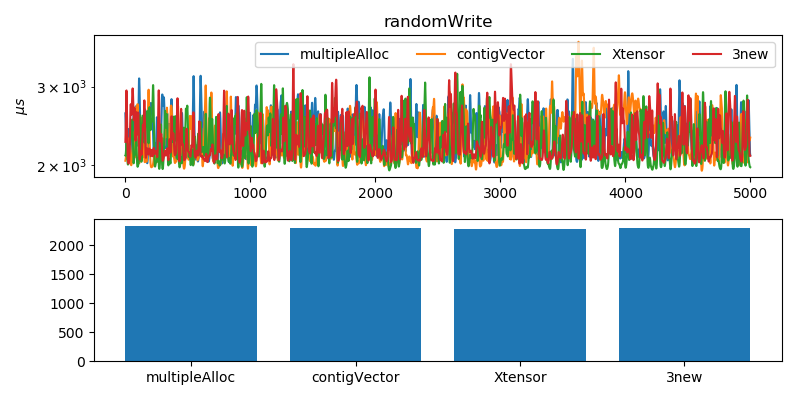

4 [2325.0992000000001, 2298.8643999999999, 2274.7105999999999, 2300.8890000000001]


In [124]:
plot('randomWrite', summary=True)

<IPython.core.display.Javascript object>


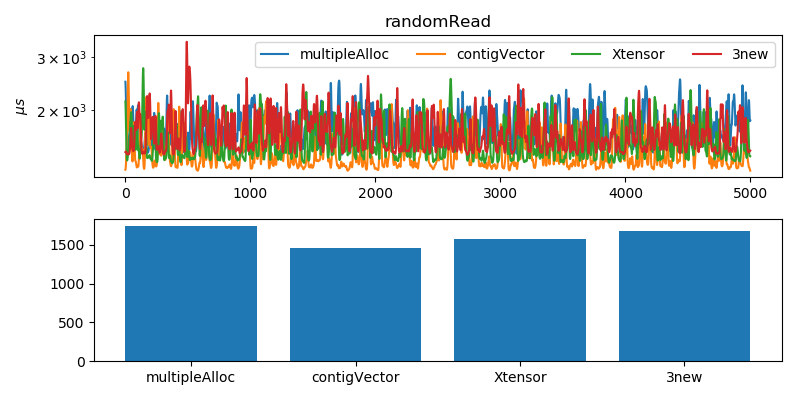

4 [1737.9770000000001, 1461.8235999999999, 1574.1876, 1675.5318]


In [125]:
plot('randomRead', summary=True)

<IPython.core.display.Javascript object>


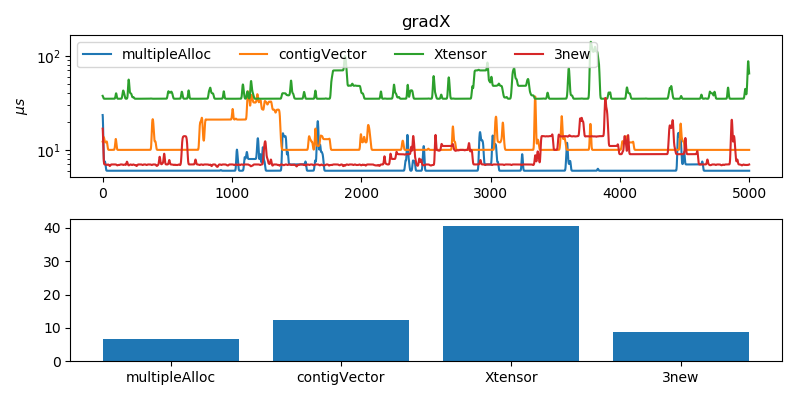

4 [6.5666000000000002, 12.4512, 40.525199999999998, 8.7184000000000008]


In [126]:
plot('gradX', summary=True)

<IPython.core.display.Javascript object>


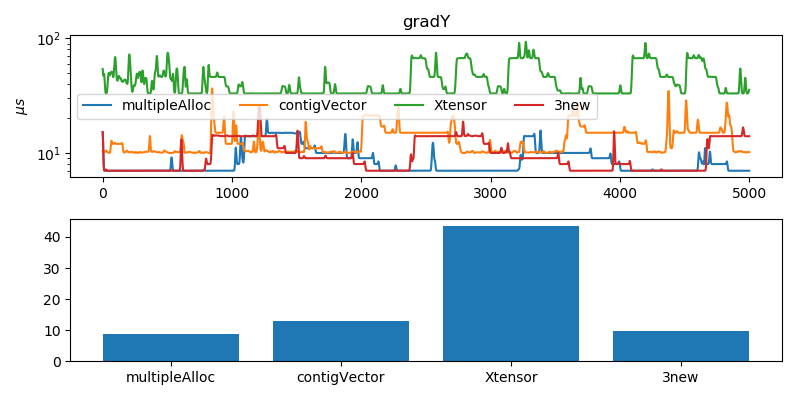

4 [8.6734000000000009, 12.9382, 43.4696, 9.718]


In [127]:
plot('gradY', summary=True)

<IPython.core.display.Javascript object>


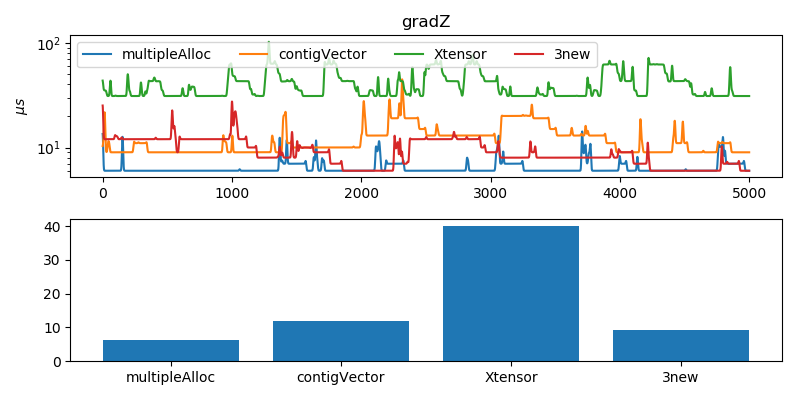

4 [6.4143999999999997, 12.0328, 39.970799999999997, 9.2609999999999992]


In [128]:
plot('gradZ', summary=True)

<IPython.core.display.Javascript object>


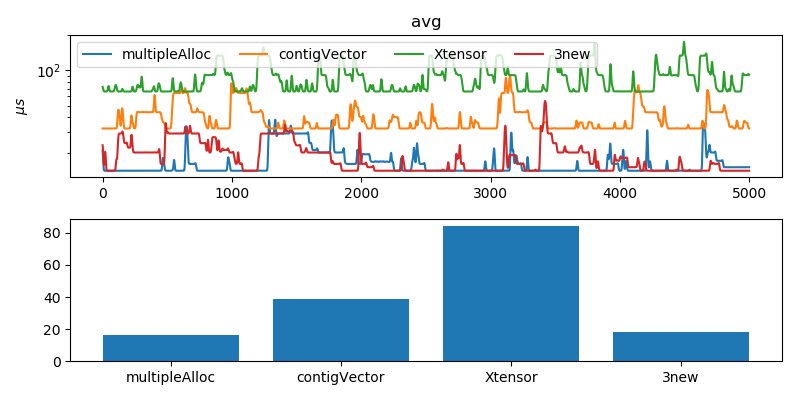

4 [16.421399999999998, 38.703600000000002, 84.196399999999997, 18.4572]


In [129]:
plot('avg', summary=True)